In [6]:
import zipfile
with zipfile.ZipFile("train.zip","r") as zip_ref:
    zip_ref.extractall("datasetdir")

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Model
from keras.layers import Flatten, Dense

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [20]:
base_model = MobileNet(input_shape=(224,224,3), include_top=False)
for layer in base_model.layers:
    layer.trainable = False

x=Flatten()(base_model.output)
x = Dense(units=7, activation='softmax')(x)

model=Model(base_model.input, x)

17225924/17225924 [==============================] - 3s 0us/step


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory = "datasetdir/train",
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              )

train_data.class_indices

Found 350 images belonging to 7 classes.


{'Angry': 0,
 'Disguist': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [28]:
val_datagen = ImageDataGenerator(rescale=1/255)
val_data = val_datagen.flow_from_directory(directory="datasetdir/train",
                                          target_size=(224,224),
                                          batch_size=32,
                                          )


Found 350 images belonging to 7 classes.


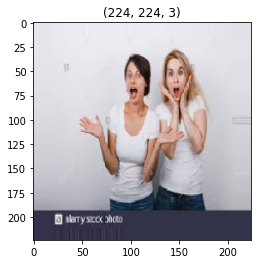

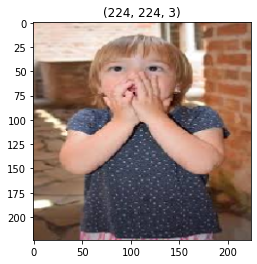

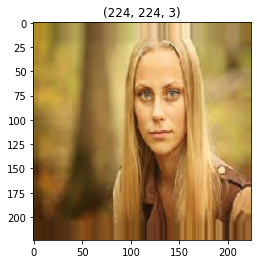

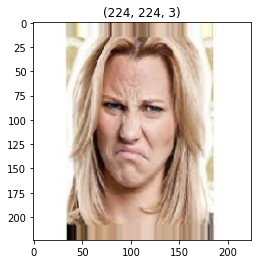

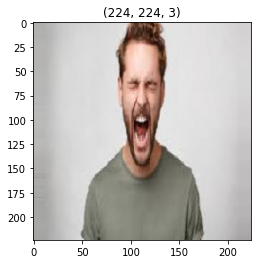

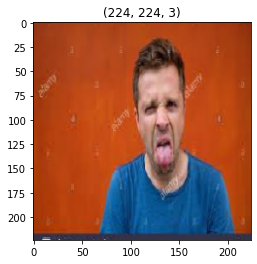

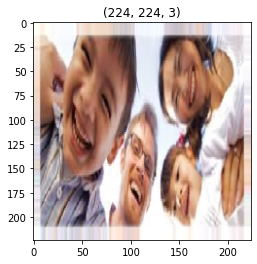

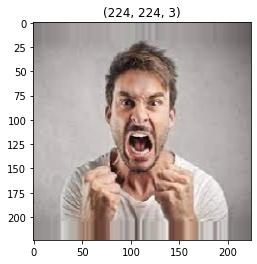

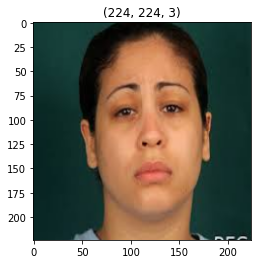

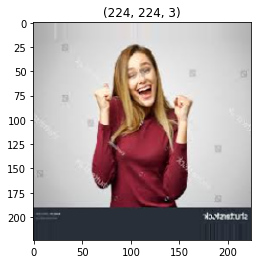

In [29]:
#Visualizing data
t_img, label = train_data.next()

def plotImages(img_arr, label):
    count=0
    for im, l in zip(img_arr, label):
        plt.imshow(im)
        plt.title(im.shape)
        plt.axis = False
        plt.show()
        
        count+=1
        if count == 10:
            break

plotImages(t_img, label)

In [30]:
#early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, verbose=1, mode='auto')

#model check point
mc = ModelCheckpoint(filepath = "best_model.h5", monitor = 'val_accuracy', verbose=1, save_best_only = True, mode='auto')

#putting callback in a list
call_back = [es, mc]

In [32]:
hist = model.fit_generator(train_data,
                          steps_per_epoch=10,
                          epochs=30,
                          validation_data = val_data,
                          validation_steps = 8,
                          callbacks = [es, mc])

C:\Users\User\AppData\Local\Temp/ipykernel_13348/3674349569.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_data,


Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 8.6714 - accuracy: 0.2138
Epoch 1: val_accuracy improved from -inf to 0.55469, saving model to best_model.h5
10/10 [==============================] - 20s 2s/step - loss: 8.6714 - accuracy: 0.2138 - val_loss: 3.6527 - val_accuracy: 0.5547
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 4.0226 - accuracy: 0.5346
Epoch 2: val_accuracy improved from 0.55469 to 0.75391, saving model to best_model.h5
10/10 [==============================] - 17s 2s/step - loss: 4.0226 - accuracy: 0.5346 - val_loss: 1.8228 - val_accuracy: 0.7539
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.9457 - accuracy: 0.7233
Epoch 3: val_accuracy improved from 0.75391 to 0.82812, saving model to best_model.h5
10/10 [==============================] - 17s 2s/step - loss: 1.9457 - accuracy: 0.7233 - val_loss: 1.0438 - val_accuracy: 0.8281
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 1.0430 -

In [33]:
#Loading the best fit model
from keras.models import load_model

model = load_model("best_model.h5")

In [34]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

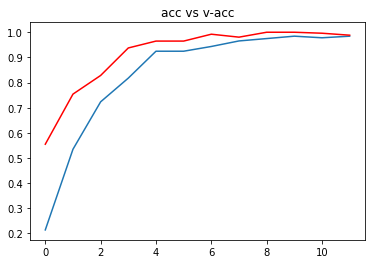

In [35]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.title("acc vs v-acc")
plt.show()

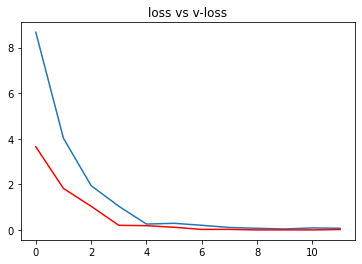

In [36]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")
plt.title("loss vs v-loss")
plt.show()

In [37]:
op = dict(zip(train_data.class_indices.values(), train_data.class_indices.keys()))

1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the image is of Happy


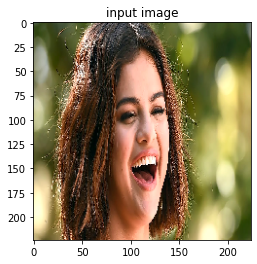

In [42]:
path = "happyface.jpg"
img = load_img(path, target_size = (224, 224))

i = img_to_array(img)/225
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f'the image is of {op[pred]}')

#diplay the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()